In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load dataset
df = pd.read_csv("data/featured_clinvar_result.csv")  # Change path if needed

In [3]:
# Drop unused columns
X = df.drop(columns=["position", "label"])
y = df["label"]

In [4]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Oversampling for class balance
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)

# Ensure correct data types
X_train = X_train.astype("int32")
X_test = X_test.astype("int32")

In [5]:
# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # (batch, seq=1, features)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

In [7]:
#  Datasets and loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [8]:
# Define Encoder-only architecture
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        out = self.fc(hidden[-1])  # Use last hidden state
        return out

In [9]:
# Model setup
input_dim = X_train.shape[1]
hidden_dim = 64
num_classes = len(np.unique(y_train))

model = Encoder(input_dim, hidden_dim, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
# Train the encoder model for 100 epochs and track metrics

# Store metrics
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

# Move model to device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
for epoch in range(1, 101):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation loop
    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_losses.append(test_loss / total)
    test_accuracies.append(correct / total)

In [11]:
# Final metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

In [12]:
# Store all final metrics in a DataFrame
import pandas as pd
metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Score": [accuracy, precision, recall, f1]
})


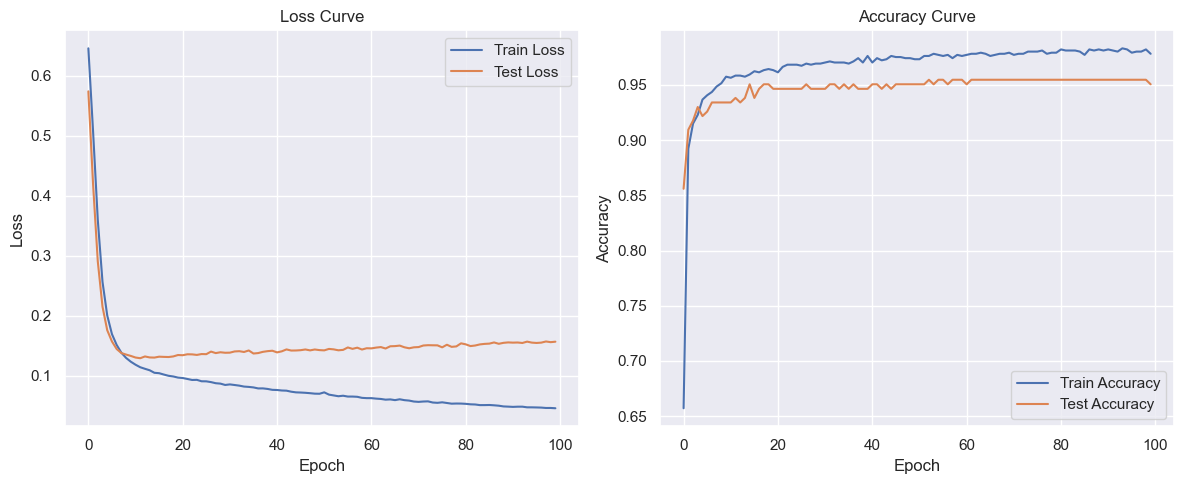

,Metric,Score
0,Accuracy,0.950617
1,Precision,0.951166
2,Recall,0.950617
3,F1-Score,0.950634


In [13]:
# Plot training and validation loss/accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

metrics_df

In [14]:
import pandas as pd
df = pd.read_csv("data/featured_clinvar_result.csv")
print(list(df.columns))


['position', 'alignment_score', 'mc_synonymous_variant', 'mc_frameshift_variant', 'mc_3_prime_UTR_variant', 'mc_5_prime_UTR_variant', 'mc_splice_donor_variant', 'mc_splice_acceptor_variant', 'mc_nonsense', 'mc_intron_variant', 'mc_missense_variant', 'mc_stop_lost', 'donor_distance', 'acceptor_distance', 'dist_to_exon_start', 'dist_to_exon_end', 'label', 'region_exon', 'region_non-exon', 'splice_type_acceptor', 'splice_type_donor', 'type', 'prev_A', 'prev_C', 'prev_G', 'prev_T', 'next_A', 'next_C', 'next_G', 'next_T', 'gc_content', 'gc_skew', 'at_content', 'position_bin', 'position_decile', 'chr_chrX', 'hotspot_flag', 'cpg_overlap']
